In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
src_folder_path = ".\\data"

In [4]:
df = pd.read_csv(src_folder_path + "\\20220415-a5ad2ede1017aadb3dd3df128cd0b0b5.csv", sep=";")
df.describe()

,acc-accuracy,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,acc-x-std,acc-y-min,acc-y-mean,acc-y-max,acc-y-var,...,ori-angle-y-min,ori-angle-y-mean,ori-angle-y-max,ori-angle-y-var,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std
count,40.0,40.000000,40.000000,40.000000,4.000000e+01,4.000000e+01,40.000000,40.000000,40.000000,4.000000e+01,...,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,2.0,-1.379788,-0.022281,0.987446,6.978704e-01,6.762119e-01,-1.746438,-0.211841,2.563359,2.277823e+00,...,-0.969261,-0.803325,-0.562417,0.013783,0.096111,-0.109191,0.157946,0.500234,0.039795,0.170082
std,0.0,1.250145,0.508431,1.097268,5.760167e-01,4.967669e-01,1.830800,0.435825,3.296349,2.713931e+00,...,0.219791,0.207121,0.297927,0.018390,0.068280,0.171506,0.077411,0.220412,0.046715,0.105575
min,2.0,-4.371919,-1.021426,-1.021425,0.000000e+00,0.000000e+00,-6.347796,-1.031233,-1.031233,0.000000e+00,...,-1.370718,-1.228527,-1.208066,0.000137,0.011719,-0.664654,0.021823,0.098491,0.000097,0.009824
25%,2.0,-2.114841,-0.334931,0.391793,3.039791e-13,5.438924e-07,-2.982266,-0.370881,-0.351943,2.877698e-13,...,-1.202225,-0.913067,-0.722185,0.002023,0.044973,-0.206177,0.104952,0.393764,0.012433,0.111337
50%,2.0,-1.002932,0.015501,1.140736,6.838841e-01,8.269627e-01,-1.031233,-0.224200,1.308390,1.652841e-01,...,-0.930540,-0.759558,-0.556204,0.005651,0.075174,-0.071181,0.149147,0.505063,0.029772,0.172544
75%,2.0,-0.670642,0.278462,1.673029,1.097508e+00,1.047618e+00,-0.351943,0.031322,4.809918,4.128356e+00,...,-0.785124,-0.679316,-0.326404,0.019784,0.140649,0.030208,0.196269,0.644133,0.050849,0.225484
max,2.0,1.323204,1.323204,2.787979,1.992234e+00,1.411465e+00,0.677691,0.677692,8.978151,9.031050e+00,...,-0.626072,-0.451886,0.018261,0.081964,0.286293,0.085434,0.370569,0.908182,0.228786,0.478315


In [5]:
df.head(4)

,startDate,endDate,acc-accuracy,acc-x-m/s^2,acc-y-m/s^2,acc-z-m/s^2,acc-x-min,acc-x-mean,acc-x-max,acc-x-var,...,ori-angle-y-max,ori-angle-y-var,ori-angle-y-std,ori-angle-z-min,ori-angle-z-mean,ori-angle-z-max,ori-angle-z-var,ori-angle-z-std,activity,device-id
0,2022-04-15T13:24:19.755Z,2022-04-15T13:24:20.917Z,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0560093, -1.0560093, -1.0560093, -1.056009...",-2.251416,0.074439,1.636770,5.756938e-01,...,-0.309417,0.005639,0.075095,0.078953,0.207923,0.383816,0.007395,0.085995,jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5
1,2022-04-15T13:24:28.971Z,2022-04-15T13:24:30.415Z,2,"[1.3120906, 1.3120906, 1.3120906, 1.3120906, 1...","[0.013930321, 0.013930321, 0.013930321, 0.0139...","[-0.8314781, -0.8314781, -0.8314781, -0.831478...",-3.314766,0.704662,1.613449,1.559865e+00,...,0.018261,0.022107,0.148685,-0.008261,0.196130,0.513810,0.020721,0.143947,jump_right,a5ad2ede1017aadb3dd3df128cd0b0b5
2,2022-04-15T13:24:33.958Z,2022-04-15T13:24:35.648Z,2,"[-0.40956223, -0.40956223, -0.40956223, -0.409...","[0.28848553, 0.28848553, 0.28848553, 0.2884855...","[0.6539097, 0.6539097, 0.6539097, 0.6539097, 0...",-0.409562,-0.409563,-0.409562,8.881784e-14,...,-0.583347,0.000161,0.012700,0.047736,0.072320,0.102460,0.000097,0.009824,stay,a5ad2ede1017aadb3dd3df128cd0b0b5
3,2022-04-15T13:24:40.081Z,2022-04-15T13:24:41.020Z,2,"[-0.40956223, -0.40956223, -0.40956223, -0.409...","[0.28848553, 0.28848553, 0.28848553, 0.2884855...","[0.6539097, 0.6539097, 0.6539097, 0.6539097, 0...",-0.535014,0.207269,1.631901,9.539479e-01,...,-0.418174,0.004574,0.067630,-0.119263,0.130644,0.441888,0.038803,0.196984,fake_jump_left,a5ad2ede1017aadb3dd3df128cd0b0b5


In [6]:
df.dtypes

startDate           object
endDate             object
acc-accuracy         int64
acc-x-m/s^2         object
acc-y-m/s^2         object
                    ...   
ori-angle-z-max    float64
ori-angle-z-var    float64
ori-angle-z-std    float64
activity            object
device-id           object
Length: 61, dtype: object

In [7]:
arrayFeatures = [
    "acc-x-m/s^2",
    "acc-y-m/s^2",
    "acc-z-m/s^2",
    "gyr-x-rad/s",
    "gyr-y-rad/s",
    "gyr-z-rad/s",
    "ori-angle-x-rad",
    "ori-angle-y-rad",
    "ori-angle-z-rad"
];

#iterate target features
for targetFeature in arrayFeatures:
    
    # convert arrays
    df[targetFeature] = df[targetFeature].apply(
        lambda x: np.fromstring(x.replace("[", "").replace("]", ""), sep=","))

In [8]:
df.columns

Index(['startDate', 'endDate', 'acc-accuracy', 'acc-x-m/s^2', 'acc-y-m/s^2',
       'acc-z-m/s^2', 'acc-x-min', 'acc-x-mean', 'acc-x-max', 'acc-x-var',
       'acc-x-std', 'acc-y-min', 'acc-y-mean', 'acc-y-max', 'acc-y-var',
       'acc-y-std', 'acc-z-min', 'acc-z-mean', 'acc-z-max', 'acc-z-var',
       'acc-z-std', 'gyr-accuracy', 'gyr-x-rad/s', 'gyr-y-rad/s',
       'gyr-z-rad/s', 'gyr-x-min', 'gyr-x-mean', 'gyr-x-max', 'gyr-x-var',
       'gyr-x-std', 'gyr-y-min', 'gyr-y-mean', 'gyr-y-max', 'gyr-y-var',
       'gyr-y-std', 'gyr-z-min', 'gyr-z-mean', 'gyr-z-max', 'gyr-z-var',
       'gyr-z-std', 'mag-accuracy', 'ori-angle-x-rad', 'ori-angle-y-rad',
       'ori-angle-z-rad', 'ori-angle-x-min', 'ori-angle-x-mean',
       'ori-angle-x-max', 'ori-angle-x-var', 'ori-angle-x-std',
       'ori-angle-y-min', 'ori-angle-y-mean', 'ori-angle-y-max',
       'ori-angle-y-var', 'ori-angle-y-std', 'ori-angle-z-min',
       'ori-angle-z-mean', 'ori-angle-z-max', 'ori-angle-z-var',
       'ori-angle-

In [9]:
def plot_data(dataArray, title):
    pltIndex = 131
    plt.figure(figsize=(14, 3))

    for curPlt in dataArray:
        plt.subplot(pltIndex)
        plt.plot(curPlt['data'])
        plt.ylabel(curPlt['name'])
        plt.grid(True)
        
        pltIndex += 1;

    plt.subplots_adjust(hspace=0.25, wspace=0.35)

    plt.suptitle(title)
    plt.show()

In [10]:
def plot_data_from_row(dataFrame, rowIndex, colNames, colLabel):
    pltData = []
    pltLabel = dataFrame.at[rowIndex, colLabel];
    
    for colName in colNames:
        pltData.append({ 'data': dataFrame.at[rowIndex, colName], 'name': colName })

    plot_data(pltData, pltLabel)

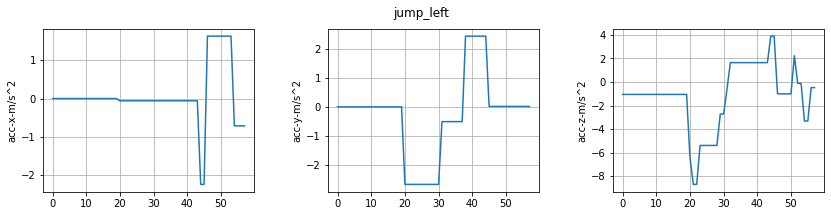

In [11]:
plot_data_from_row(df, 0, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')

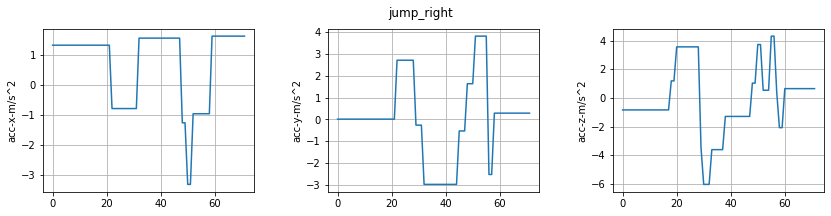

In [12]:
plot_data_from_row(df, 1, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')

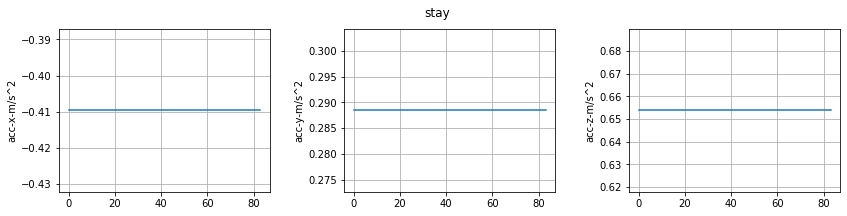

In [13]:
plot_data_from_row(df, 2, ['acc-x-m/s^2', 'acc-y-m/s^2', 'acc-z-m/s^2'], 'activity')